# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Описание проекта**

Заказчик этого исследования — сеть отелей «Как в гостях».   
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.    
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные**
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.   
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.    
    
Стоимость номеров отеля:   
*категория A: за ночь — 1 000, разовое обслуживание — 400;    
категория B: за ночь — 800, разовое обслуживание — 350;    
категория C: за ночь — 600, разовое обслуживание — 350;    
категория D: за ночь — 550, разовое обслуживание — 150;    
категория E: за ночь — 500, разовое обслуживание — 150;    
категория F: за ночь — 450, разовое обслуживание — 150;    
категория G: за ночь — 350, разовое обслуживание — 150.*    
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.    
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.   

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
random.seed(489)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler 

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-darkgrid')

In [2]:
df_train = pd.read_csv('/datasets/hotel_train.csv') #датасет с тренировочными даными 
df_test = pd.read_csv('/datasets/hotel_test.csv') #датасет с тестовыми даными 

### Шаг 2. Предобработка и исследовательский анализ данных

Что бы упростить себе работу, предлагаю для начала объеденить два датасета при помощи `concat`. Обработать их вместе и после этого разделить их обратно на `df_train` и на `df_test`. Для начала я хочу убедится, что столбцы одинаковые, имеют одинаковый тип данных. И так же проверю, есть ли лишние пробелы в названии столбцов 

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [5]:
for i in [df_train, df_test]:
    print(i.columns, '\n')

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object') 

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', '

Проверка проведена успешно, теперь можем смело объединять наши таблицы

In [6]:
df = pd.concat([df_train, df_test]) #объединяю таблицы 

In [7]:
df.info() # так же перепроверяю основную информацию о таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97641 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              97641 non-null  int64  
 1   is_canceled                     97641 non-null  int64  
 2   lead_time                       97641 non-null  float64
 3   arrival_date_year               97641 non-null  int64  
 4   arrival_date_month              97641 non-null  object 
 5   arrival_date_week_number        97641 non-null  int64  
 6   arrival_date_day_of_month       97641 non-null  int64  
 7   stays_in_weekend_nights         97641 non-null  int64  
 8   stays_in_week_nights            97641 non-null  int64  
 9   adults                          97641 non-null  float64
 10  children                        97641 non-null  float64
 11  babies                          97641 non-null  float64
 12  meal                            

In [8]:
df['id'].nunique() #проверяю действительно ли id содержит только уникальные значения. 

97641

Столбец `id` содержит только уникальные значения. В ML он нам не понадобится. Поэтому мы можем смело его удалять

In [9]:
df = df.drop(columns = ['id']) #удаляем столбец

In [10]:
df['is_canceled'].value_counts() #смотрим на распределение ключевого значения

0    61006
1    36635
Name: is_canceled, dtype: int64

Да, у бизнеса большие проблемы. Из 97641 заказов, 36635 отменили. 

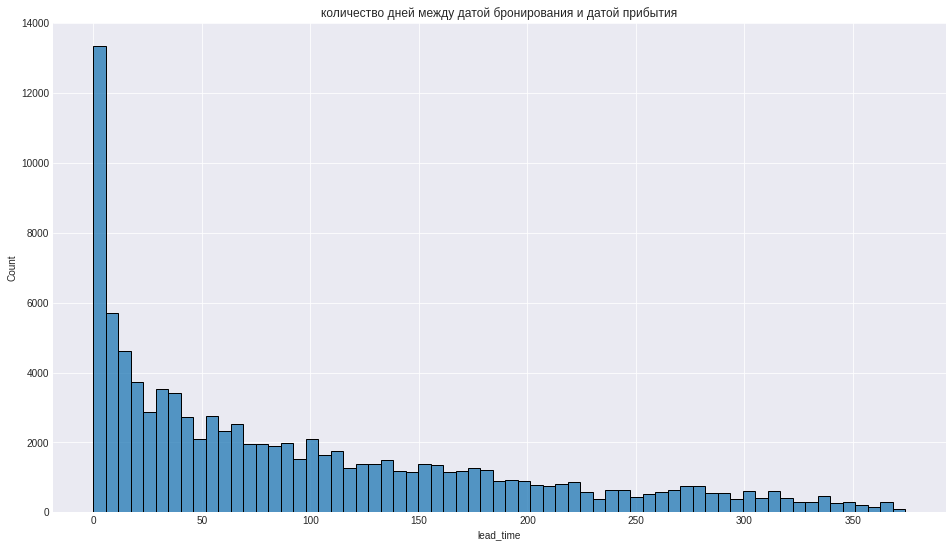

In [11]:
plt.figure(figsize=(16,9))
sns.histplot(df['lead_time'], label = 'lead_time')
plt.title("количество дней между датой бронирования и датой прибытия")
plt.show();

По времени ожидания можем оценить, что некоторые планируют свой отпуск за целый год

In [12]:
#для удобства в будущем, я решил переименовать значения месяцев 
df['arrival_date_month'].replace({'January': 1, 'February': 2, 'March': 3, 
                                  'April': 4, 'May': 5, 'June': 6,
                                  'July': 7, 'August': 8, 'September': 9, 
                                  'October': 10, 'November':11, 'December': 12}, inplace = True)

In [13]:
# изменим тип данных некоторых столбцов
df.loc[:,['adults', 'children', 
          'babies','lead_time']] = df.loc[:,['adults', 'children', 'babies','lead_time']].astype(dtype = 'int64')

In [14]:
# посмотрим какие года затрагивают датасеты 
for i,y in zip([df, df_train, df_test],['df', 'df_train', 'df_test']):
    print(f'В {y} содержится информация о следующих годах', i['arrival_date_year'].unique())

В df содержится информация о следующих годах [2015 2016 2017]
В df_train содержится информация о следующих годах [2015 2016]
В df_test содержится информация о следующих годах [2017]


Тестовые данные содержат информацию только за 2017 год. Обучать модель будет на данных за 2015/2016 год

In [15]:
# вывожу информацию, о количестве заказов и количестве отменённых заказов
df.groupby(['arrival_date_year','arrival_date_month'])['is_canceled'].agg(['count', 'sum']).sort_values(
    by = ['arrival_date_year','arrival_date_month']).reset_index()

,arrival_date_year,arrival_date_month,count,sum
0,2015,7,2185,1130
1,2015,8,3116,1403
2,2015,9,4443,1910
3,2015,10,4284,1515
4,2015,11,1930,415
5,2015,12,2370,819
6,2016,1,1892,487
7,2016,2,3358,1182
8,2016,3,4148,1277
9,2016,4,4804,1886


У нас есть информация за 26 месяцев. 
По таблице мы можем оценить, что приблизительно треть заказов, а в некоторых случаях и половина заказов отменяется.    
Основной пик заказов приходится на середину весны Хотя в 2016 было так же много заказов и в осенние месяцы.  
Худщие месяца приходятся на конец года.


Попробуем информацию графически отобразить нашу информацию

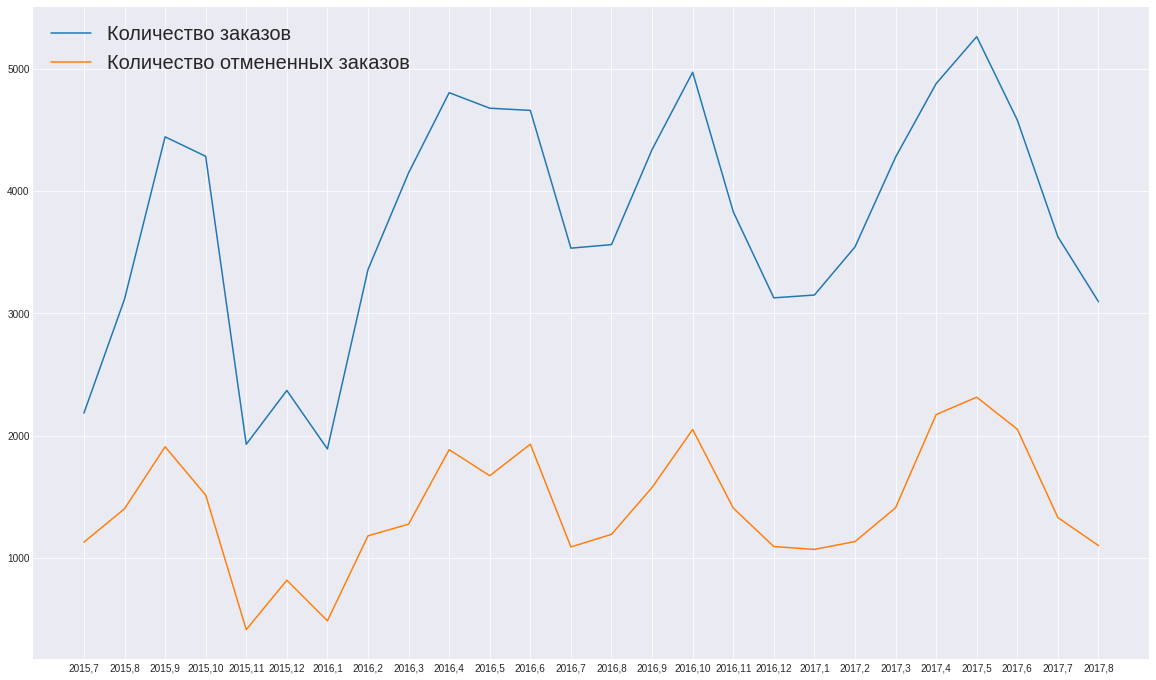

In [16]:
i = df.groupby(['arrival_date_year', 'arrival_date_month'])['is_canceled'].agg(['count', 'sum']).sort_values(
    by = ['arrival_date_year', 'arrival_date_month']).reset_index()
 

i['index'] = i['arrival_date_year'].astype(str)+ ',' +i['arrival_date_month'].astype(str)


fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(i['count'], label ='Количество заказов')
ax.plot(i['sum'], label = 'Количество отмененных заказов')
ax.set_xticks(i.index)
ax.set_xticklabels(i['index'])
ax.legend(fontsize = 20)
plt.show()

In [17]:
df['babies'].value_counts() # смотрим значения о детях

0     97014
1       618
2         7
9         1
10        1
Name: babies, dtype: int64

В количестве младенцев был выявлен аномальный выброс  в 9 и 10 штук. Предполагаю, что это опечатка и клиенты хотели написать 1 младенец

In [18]:
df.loc[df['babies'].isin([10, 9]), 'babies'] = 1 # произвожу замену 

In [19]:
df.loc[(df['adults'] == 0) & (df['babies'] == 0) & (df['children'] == 0)].head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,0,48,2016,2,9,21,2,4,0,0,0,SC,CHE,Direct,0,0,0,B,2,0,Transient-Party,0,0,6
26878,0,122,2016,5,19,5,2,4,0,0,0,SC,PRT,TA/TO,0,0,0,E,3,0,Transient,0,0,6
26879,0,122,2016,5,19,5,2,4,0,0,0,SC,CHE,TA/TO,0,0,0,E,3,0,Transient,0,0,6
31570,0,256,2016,8,35,21,3,5,0,0,0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,0,8
41461,0,0,2015,11,49,30,1,2,0,0,0,SC,PRT,Corporate,1,0,1,A,2,0,Transient,0,0,3


Так же прошу обратить внимание, что обнаружены клиенты у которых 0 взрослых, 0 детей и 0 младенцев.   
Возможно это подростки от 14 до 21года. Надо уточнить с какого возраста клиент заносится в категорию взрослые. 
у 235 клиентов было заявлено 0 взрослых.    
Возможно ли, что в стране где находится данная сеть отелей, очень популярны путешествия будучи подростком?? 

In [20]:
df['meal'].unique() # проверяем значения опций заказов

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [21]:
df['meal'] = df['meal'].apply(lambda x: x.strip())  #убираю лишние пробелы

In [22]:
display(df['country'].unique()) #уникальные значения в столбце Country
display(df['country'].nunique()) #количество уникальных значений

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

174

В странах лишних пробелов не обнаруженно. Так же очень большое количество посетителей из разных стран.    
Заявлено 174 страны. 

Посмотрим какие уникальные значения стран содержаться лишь в одном датасете и не содержаться в другом

In [23]:
print([x for x in df_test['country'].unique() if x not in df_train['country'].unique()])
print([x for x in df_train['country'].unique() if x not in df_test['country'].unique()])

['FJI', 'MDG', 'CAF', 'NPL', 'BHS', 'UMI', 'MYT', 'GTM', 'GHA', 'ASM', 'TGO', 'MRT', 'NCL', 'KIR', 'SDN', 'ATF', 'SLE', 'LAO', 'FRO']
['BWA', 'SMR', 'CYM', 'GGY', 'ARM', 'OMN', 'BDI', 'PLW', 'MWI', 'KNA', 'HND', 'GEO', 'ZMB', 'KHM', 'NIC', 'VGB', 'MKD', 'TMP', 'GLP', 'MMR', 'BFA', 'MLI', 'NAM', 'BOL', 'BRB', 'DMA', 'PYF', 'UGA', 'GUY', 'LCA', 'RWA']


In [24]:
#смотрим сколько было отменненых заказов у клиентов 
df['previous_cancellations'].value_counts().sort_values(ascending = False)

0     91777
1      5532
2        83
3        57
11       35
24       28
6        22
25       19
26       18
19       17
4        15
5        14
13       12
14       11
21        1
Name: previous_cancellations, dtype: int64

Некоторые клиенты очень часто отменяют заказы. 26 отменённых заказов. Но справедливости ради количество таких клиентов очень мало

In [25]:
df['previous_bookings_not_canceled'].unique()

array([ 0,  1,  2,  3,  4,  5,  6, 10, 12, 13, 15, 21,  7,  9,  8, 11, 14,
       18, 22, 16, 17, 19, 20, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 25, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72])

В противовес у некоторых клиентов более 60 подтвержденных заказов. P.s. полностью происледовав данные выявленно, что после 31го заказа это один и тот же клиент

In [26]:
df[df['previous_bookings_not_canceled'] >= 31].head(15)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
39746,0,5,2016,5,20,10,0,1,1,0,0,BB,PRT,Corporate,1,3,31,A,0,0,Transient,0,0,1
39747,0,2,2016,5,21,15,2,1,1,0,0,BB,PRT,Corporate,1,3,32,A,0,0,Transient-Party,0,0,3
39748,0,7,2016,5,22,23,1,2,1,0,0,BB,PRT,Corporate,1,3,33,A,1,0,Transient,1,0,3
39749,0,3,2016,5,23,30,1,2,1,0,0,BB,PRT,Corporate,1,3,34,A,0,0,Transient,0,0,3
39750,0,13,2016,6,25,14,0,3,1,0,0,BB,PRT,Corporate,1,3,35,A,2,0,Transient,0,1,3
39751,0,4,2016,6,26,21,0,1,1,0,0,BB,PRT,Corporate,1,3,36,A,1,0,Transient,1,0,1
39752,0,2,2016,7,29,10,2,1,1,0,0,BB,PRT,Corporate,1,3,37,A,1,0,Transient,0,0,3
39753,0,5,2016,7,30,18,1,1,1,0,0,BB,PRT,Corporate,1,3,38,A,1,0,Transient,0,2,2
39754,0,2,2016,7,31,24,2,0,1,0,0,BB,PRT,Corporate,1,3,39,A,2,0,Transient-Party,0,0,2
39755,0,1,2016,7,32,31,2,1,1,0,0,BB,PRT,Corporate,1,3,40,A,1,0,Transient,0,2,3


Постоянный клиент(1 взрослый) из Португалии, несколько раз в месяц останавливается в отелях данной сети на срок от 1 до 3 дней

In [27]:
df['reserved_room_type'].unique() # проверяю какого типа резервировали команаты

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [28]:
df['reserved_room_type'] = df['reserved_room_type'].apply(lambda x: x.strip()) #удаляю лишние пробелы 

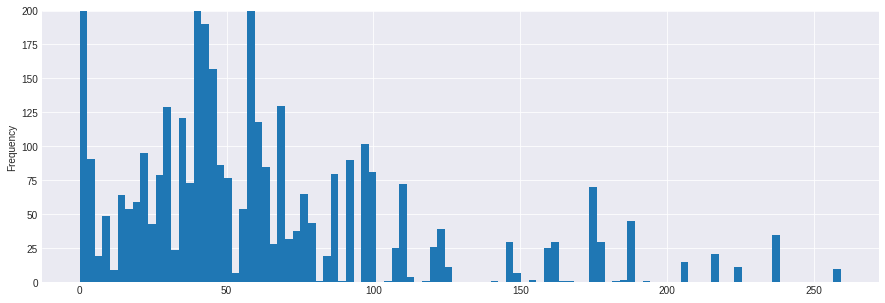

In [29]:
#посмотрим сколько дней ожидал заказ подтверждение
df['days_in_waiting_list'].plot(kind = 'hist', bins = 100, grid = True, figsize = (15,5), ylim = [0, 200]);

В некоторых случаях заказ ожидал подтверждение больше полу-года 

In [30]:
df['required_car_parking_spaces'].value_counts() #сколько парковочных мест обычно требовалось

0    92482
1     5138
2       17
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

3 и 8 мест для машин? 

In [31]:
df[df['required_car_parking_spaces'] >= 3].head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
64080,0,13,2016,12,50,5,1,0,1,0,0,BB,NLD,TA/TO,0,0,0,A,0,0,Transient,3,0,1
2549,0,26,2017,3,11,14,0,5,2,0,0,HB,AUT,Corporate,1,0,2,E,1,0,Transient-Party,8,1,5
2550,0,138,2017,3,12,19,2,2,2,0,0,HB,AUT,Corporate,1,0,2,E,1,122,Transient-Party,8,0,4
25031,0,30,2017,4,17,29,2,1,2,0,0,SC,ESP,TA/TO,0,0,0,A,0,0,Transient-Party,3,2,3


Учитывая, что было максимум 2ое взрослых в данных заказов. Предполагаю, что произошла отпечатка

In [32]:
df.loc[df['required_car_parking_spaces'] >=3, 'required_car_parking_spaces'] = 2

In [33]:
df['total_nights'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  8, 10,  9])

In [34]:
df.describe(datetime_is_numeric = True)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00,97641.00
mean,0.38,96.75,2016.14,6.48,26.85,15.78,0.84,2.26,1.84,0.08,0.01,0.03,0.09,0.13,0.20,2.31,0.05,0.56,3.10
std,0.48,93.05,0.71,3.13,13.77,8.75,0.85,1.36,0.48,0.34,0.08,0.17,0.80,1.53,0.61,15.22,0.23,0.78,1.74
min,0.00,0.00,2015.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.00,19.00,2016.00,4.00,16.00,8.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,0.00,68.00,2016.00,6.00,27.00,16.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
75%,1.00,152.00,2017.00,9.00,38.00,23.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00
max,1.00,374.00,2017.00,12.00,53.00,31.00,4.00,6.00,4.00,3.00,2.00,1.00,26.00,72.00,18.00,259.00,2.00,5.00,10.00


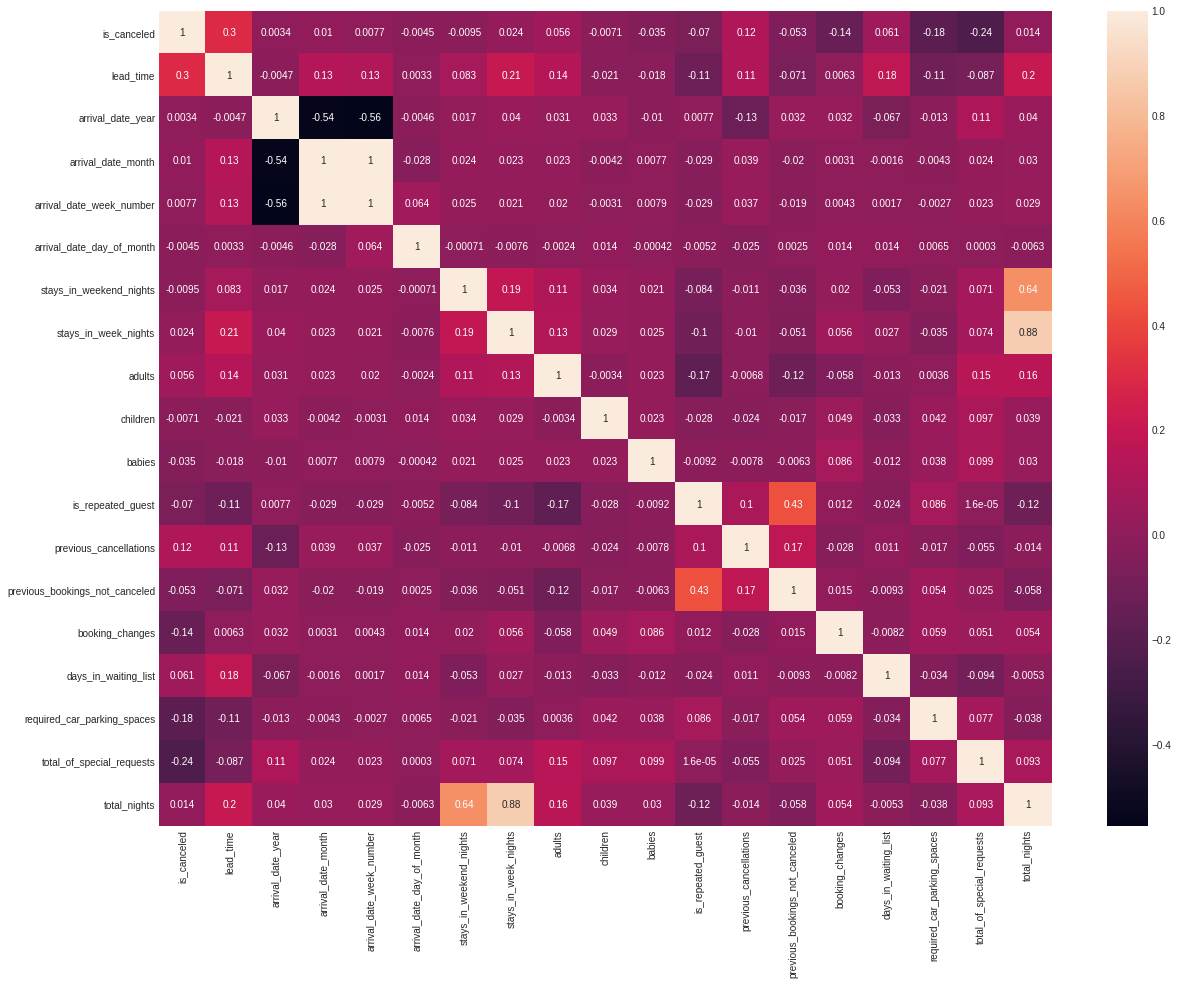

In [35]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### Вывод 

Про данную сеть отелей можно сказать следующее   
Количество отмененных заказов из всего датасета = 38%   
По медиане люди резервировали номер за 68 дней до приезда и бронировали на 3 дня ('по медиане')      
Постояльцы данной сети очень редко приезжают с детьми/младенцами      
И только 3% клиентов бронировали номер второй раз     
14% клиентов изменяют параметры брони      
И только 5% клиентам требуется парковочное место 
По матрице корреляций можно сказать, что количество дней в будни/выходные положительно коррелируют с финальным количеством дней(логично)
Количество подтверждённых заказов коррелирует (на 0.43) с тем, что гость бронирует номер второй раз

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Требуется посчитать прибыль получаемых с клиента.    
Подсчёты будут выполняться следующим образом    
**Стоимость номера * количество дней * на сезонный коэффициент - затраты на уборку(которые проводятся раз в два дня)**

Если клиент отменил заказ, то убытком считаем **суточный простой номера.** 

In [36]:
def profit(i):
    SPRING_AUTUMN = [3, 4, 5, 9, 10, 11] #весенний и осенний сезон 
    SUMMER = [6, 7, 8] #летний сезон
    COST = {'A':1000, 'B':800, 'C':600, 'D':550, 'E':500, 'F':450, 'G':350} #стоимость номера
    SERVICE = {'A':400, 'B':350, 'C':350, 'D':150, 'E':150, 'F':150, 'G':150} #стоимость обслуживания номера
    if (i['arrival_date_month'] in SPRING_AUTUMN):
        coef = 1.2
    elif (i['arrival_date_month'] in SUMMER):
        coef = 1.4
    else:
        coef = 1.0
    if (i['is_canceled'] == 1):
        return -COST[i['reserved_room_type']] * coef - SERVICE[i['reserved_room_type']]
    else:
        return i['total_nights']*COST[i['reserved_room_type']]*coef - SERVICE[i['reserved_room_type']]*np.ceil(
            i['total_nights']/2)

In [37]:
df['profit'] = df.apply(profit, axis = 1) # применяем функцию 

In [38]:
#прибыль сети отелей по месяцам
df.groupby(['arrival_date_year','arrival_date_month'])['profit'].sum().reset_index().sort_values(
    by = ['arrival_date_year', 'arrival_date_month'], ascending = False)

,arrival_date_year,arrival_date_month,profit
25,2017,8,5282910.00
24,2017,7,5333310.00
23,2017,6,4715090.00
22,2017,5,4224610.00
21,2017,4,4558730.00
20,2017,3,5469520.00
19,2017,2,3274850.00
18,2017,1,2441750.00
17,2016,12,2724950.00
16,2016,11,4208460.00


In [39]:
#убытки вызванные отменой заказов по месяцам
df[df['profit'] < 0].groupby(['arrival_date_year','arrival_date_month'])['profit'].sum().reset_index().sort_values(
    by = ['arrival_date_year', 'arrival_date_month'], ascending = False)

,arrival_date_year,arrival_date_month,profit
25,2017,8,-1672440.00
24,2017,7,-2027370.00
23,2017,6,-3315270.00
22,2017,5,-3276610.00
21,2017,4,-3037930.00
20,2017,3,-1955740.00
19,2017,2,-1405100.00
18,2017,1,-1351100.00
17,2016,12,-1306800.00
16,2016,11,-2108560.00


#### Вывод

Мы смогли посчитать доход. Меньше всего заказов приходится на зимний период. Можно так же заметить, что зимной количество отменённых заказов тоже становится меньше. 

Заявлять, что доля отменнённых заказов уменьшилась нельзя. Это вызвано с уменьшением посетителей зимой

### Шаг 4. Разработка модели ML

#### Обучение деревянных моделей

Я создам копию датафрейма, и так же копию тестовых данных до обработки 

In [40]:
df = df.reset_index(drop = True) #обновляем индексы
df_copy = df.copy() # создаём копию
test_copy = df.iloc[65229:,:].reset_index(drop = True).copy() #так же создаю копию тестовых данных 

In [41]:
df.drop(columns = ['profit','arrival_date_year'], inplace = True ) #удаляю столбец с годами и прибылью

In [42]:
#преобразую категориальные величины при помощи OrdinalEncoder

encoder = OrdinalEncoder() 
columns1 = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']


df[columns1] = pd.DataFrame(encoder.fit_transform(df[columns1]), columns = df[columns1].columns)

In [43]:
df_train = df.iloc[0:65229, :].reset_index(drop = True) #тренировочная выборка
df_test = df.iloc[65229:,:].reset_index(drop = True) #тестовая выборка

In [44]:
for i in df_test, df_train: #проверяем размеры
    print(i.shape)

(32412, 23)
(65229, 23)


In [45]:
#провожу масштабирование признаков

scaler = StandardScaler() 
numeric = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
           'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 
           'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

scaler.fit(df_train[numeric]) #обучаю на тренировочной выборке 
df_train[numeric] = scaler.transform(df_train[numeric]) #применяю к тренировочной
df_test[numeric] = scaler.transform(df_test[numeric]) #применяю к тестовой

Далее разделяем датасет на признаки и на целовй признак

In [46]:
features_test = df_test.drop(['is_canceled'], axis = 1) # тестовые признаки 
features_train = df_train.drop(['is_canceled'], axis = 1) #тренировочные признаки

target_test = df_test['is_canceled'] #тестовый целевой признак
target_train = df_train['is_canceled'] #тренировочный целевой признак

In [47]:
print('Размеры выборок')
print(f'Тренировочная с признаками: {features_train.shape}\nТестовая с признакми: {features_test.shape}\n')
print(f'Тренировочная с целевым признаком: {target_train.shape}\nТестовая с целевым признаком: {target_test.shape}')

Размеры выборок
Тренировочная с признаками: (65229, 22)
Тестовая с признакми: (32412, 22)

Тренировочная с целевым признаком: (65229,)
Тестовая с целевым признаком: (32412,)


Для того что бы понять, какая модель лучше всего подойдёт применяю кросс-валидацию, с оцениванием при помощи f1. Самой лучшей модели я применю кросс-валидацию с перебором гиперпараметров

In [48]:
#кроссвалидация  дерева решения 

model = DecisionTreeClassifier(random_state=0, class_weight = 'balanced') 
scores = cross_val_score(model, features_train, target_train, cv=5, scoring = 'f1') 
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.4339011508452867


In [49]:
#кроссвалидация случайного леса 

model = RandomForestClassifier(random_state = 123, class_weight = 'balanced')
scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'f1')
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.44951582992962325


In [50]:
f1_mean = 0 #f1 score
best_depth = 0  #глубина дерева
best_est = 0   #число деревьев 
random_forest_model = None 


for est in range (10,50,3):
    for depth in range (5, 8):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth, class_weight = 'balanced')
        scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'f1')
        final_f1 =  scores.mean()
        
        if f1_mean < final_f1:
            f1_mean = final_f1
            best_depth = depth 
            best_est = est
            random_forest_model = model
        
                
                
print('Средняя F1 - мера =', f1_mean)
print('Число деревьев: ', best_est)
print('Глубина дерева: ', best_depth)

Средняя F1 - мера = 0.5938643162756302
Число деревьев:  19
Глубина дерева:  5


F1 - мера вышла 0.59 
Так же мы узнали необходимые параметры случайного леса. Теперь обучим нашу модель с данными параметрами и посмотрим результат на тестовой выборке  

In [51]:
model = random_forest_model.fit(features_train, target_train)
predict_test = model.predict(features_test)
print('Доля правильных ответов на тестовой выборке =',accuracy_score(target_test, predict_test))
print('f1 score на тестовой выборке =',f1_score(target_test, predict_test))
print('Точность',precision_score(target_test, predict_test))
print('Полнота',recall_score(target_test, predict_test))

Доля правильных ответов на тестовой выборке = 0.7537023324694557
f1 score на тестовой выборке = 0.6119294151961499
Точность 0.7887218045112782
Полнота 0.49988086728615677


На тестовой выборке параметры гораздо выше. 
Возможно это вызвано тем, что при кросс-валидации мы обучали каждый раз на части тренировочных данных и выводили среднее от всего качества обучения 

Так же в нашей задаче очень высокая точность, но очень низкое значение полноты. 
Учитывая, что нам очень важно правильно определить клиентов, которые отменяют заказ, то возможно мне стоило отбирать модели по наиболее высокому значению полноты  

Теперь попробую узнать, какие параметры играли более высокую роль 

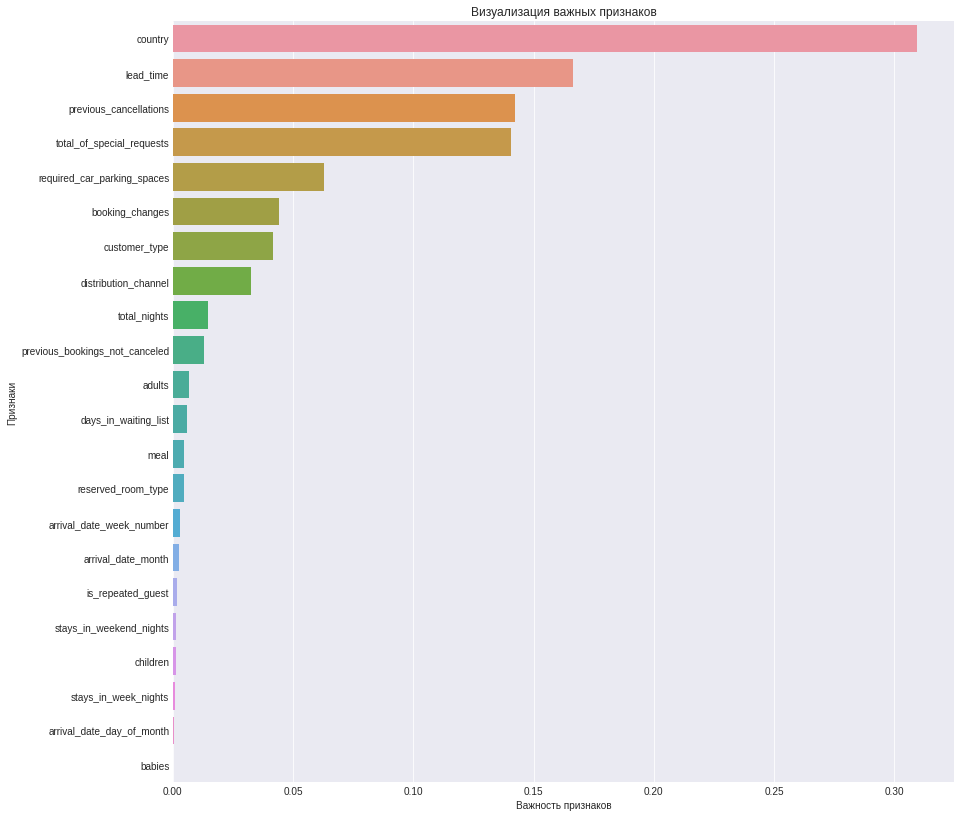

In [52]:
#выделяю важнейшие признаки 
feature_imp = pd.Series(model.feature_importances_,index=features_train.columns).sort_values(ascending=False) 

# создаю столбчатую диаграмму
fig, scatter = plt.subplots(figsize = (14,14))
scatter = sns.barplot(x=feature_imp, y=feature_imp.index) 
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

Наиболее важным параматером для обучения оказалось `количество отменёных заказов`, на 1ом месте `страна`. Возможно это вызвано тем, что я не правильно обработал признак по странам. И даже в "деревянном" алгоритме не порядоковые категориальные данные следует обрабатывать OHE...  Так же меня напрягает очень резкий прирост в качестве после обучения модели. Я на всякий случай проверю модель на адекватность

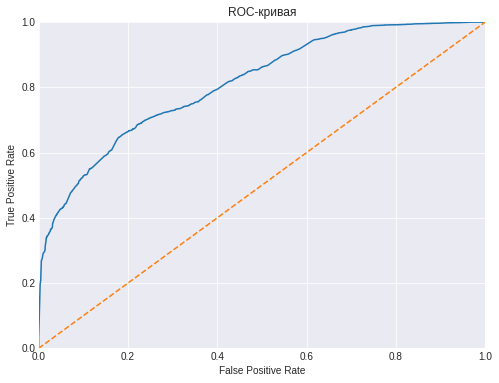

In [53]:
test_predictions = random_forest_model.predict_proba(features_test)
test_predictions = test_predictions[:,1]
fpr, tpr, thresholds = roc_curve(target_test, test_predictions)

plt.figure(figsize = (8,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [54]:
roc_auc_score(target_test, test_predictions)    #даю оценку моей модели при помощи roc_auc_score

0.8131191585867368

Рок_аук = 0.81, что не может не радовать. Значит модель можно использовать. 

#### Обучение моделей на данных обработанных при помощи ОНЕ

Далее я попробую обработать данные по другому. Применить ОНЕ + обработать циклические данные и посмотреть на результат 

In [55]:
df_copy.drop(columns = ['profit', 'arrival_date_year'], inplace = True) # удаляю лишние столбцы 

Потом идёт обработка циклических данных

In [56]:
df_copy['arrival_date_month_sin'] = np.sin((df_copy['arrival_date_month']-1)*(2.*np.pi/12))
df_copy['arrival_date_week_number_sin'] = np.sin((df_copy['arrival_date_week_number']-1)*(2.*np.pi/53))
df_copy['arrival_date_day_of_month_sin'] = np.sin((df_copy['arrival_date_day_of_month']-1)*(2.*np.pi/31))

df_copy['arrival_date_month_cos'] = np.cos((df_copy['arrival_date_month']-1)*(2.*np.pi/12))
df_copy['arrival_date_week_number_cos'] = np.cos((df_copy['arrival_date_week_number']-1)*(2.*np.pi/53))
df_copy['arrival_date_day_of_month_cos'] = np.cos((df_copy['arrival_date_day_of_month']-1)*(2.*np.pi/31))

df_copy.drop(columns = ['arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month'], inplace = True)

Для обработки при помощи ОНЕ. Мне надо выделить категориальные столбцы. Обработать их при помощи ОНЕ. 
Удалить их из исходного датасета и добавить обновленные столбцы к исходному датасету

In [57]:
columns2 = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
df_one = pd.get_dummies(df_copy[columns2], drop_first=True)

df_copy.drop(columns = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type'], inplace = True)

df_copy= pd.concat([df_copy, df_one], axis = 1)

In [58]:
df_copy.shape # вывожу размеры датасета 

(97641, 209)

In [59]:
df_train2 = df_copy.iloc[0:65229, :].reset_index(drop = True) #разбиваю на тренировочные данные
df_test2 = df_copy.iloc[65229:,:].reset_index(drop = True)  #разбиваю на тестовые данные

In [60]:
#выборки с признаками
features_test2 = df_test2.drop(['is_canceled'], axis = 1)
features_train2 = df_train2.drop(['is_canceled'], axis = 1)

#выборки с целевым признаком
target_test2 = df_test2['is_canceled']
target_train2 = df_train2['is_canceled']

In [61]:
print('Размеры выборок')
print(f'Тренировочная с признаками: {features_train2.shape}\nТестовая с признаками: {features_test2.shape}\n')
print(f'Тренировочная с целевым признаком: {target_train2.shape}\nТестовая с целевым признаком: {target_test2.shape}')

Размеры выборок
Тренировочная с признаками: (65229, 208)
Тестовая с признаками: (32412, 208)

Тренировочная с целевым признаком: (65229,)
Тестовая с целевым признаком: (32412,)


In [62]:
#Модель дерева решения
model = DecisionTreeClassifier(random_state=0, class_weight = 'balanced')
scores = cross_val_score(model, features_train2, target_train2, cv=5, scoring = 'f1') 
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.4040170192824899


In [63]:
#модель случайного леса
model = RandomForestClassifier(random_state = 123, class_weight = 'balanced')
scores = cross_val_score(model, features_train2, target_train2, cv = 5, scoring = 'f1')
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.43744654307511455


In [64]:
#модель К-ближ. соседей
model = KNeighborsClassifier()
scores = cross_val_score(model, features_train2, target_train2, cv = 5, scoring = 'f1')
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.37322495974832903


In [65]:
#модель логистической регрессии 
model = LogisticRegression(solver = 'newton-cg')
scores = cross_val_score(model, features_train2, target_train2, cv = 5, scoring = 'f1')
final_score = scores.mean()

print('Средняя f1 мера:', final_score)

Средняя f1 мера: 0.5738468632438527


По средней F1_мере оказалось лучше всего обучение случайного леса при помощи OrdinalEncoder. Выбираем данную модель 

In [66]:
#объединяю наш сохранённый тестовый датасет с нашими предсказаниями 
test_copy = pd.concat([test_copy, pd.Series(predict_test)], axis = 1)
test_copy.head() #проверяю как выглядит наш датасет

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,profit,0
0,1,74,2017,1,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,-1400.00,1
1,1,62,2017,1,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,-1400.00,0
2,1,62,2017,1,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,-1400.00,0
3,1,71,2017,1,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,-1400.00,1
4,1,172,2017,1,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,-1400.00,0


In [67]:
test_copy['profit'].sum() #узнаю прибыль с данного датасета

35300770.0

Если ML распознаёт, что человек может отменить заказ, то он должен внести 80% от стоимости номера за одни сутки и затрат на разовую уборку

In [68]:
def profit_ML(df):
    SPRING_AUTUMN = [3, 4, 5, 9, 10, 11] #весенний и осенний сезон 
    SUMMER = [6, 7, 8] #летний сезон
    COST = {'A':1000, 'B':800, 'C':600, 'D':550, 'E':500, 'F':450, 'G':350} # стоимость номера 
    SERVICE = {'A':400, 'B':350, 'C':350, 'D':150, 'E':150, 'F':150, 'G':150} # стоимость обслуживания
    if (df[0] == 1) and (df['is_canceled'] == 1):
        if df['arrival_date_month'] in SPRING_AUTUMN:
            return (COST[df['reserved_room_type']] * 0.96) - (SERVICE[df['reserved_room_type']] * 0.2)
        elif df['arrival_date_month'] in SUMMER:
            return (COST[df['reserved_room_type']] * 1.12) - (SERVICE[df['reserved_room_type']] * 0.2)
        else:
            return (COST[df['reserved_room_type']] * 0.8) - (SERVICE[df['reserved_room_type']] * 0.2)  
    else:
        return df['profit']

In [69]:
test_copy['profit_ML'] = test_copy.apply(profit_ML, axis = 1) #применяем функцию 

In [70]:
int(test_copy['profit_ML'].sum() - test_copy['profit'].sum()) #узнаём какую прибыль принесёт наша модель за 8 месяцев работы

15047034

#### Вывод

Введение ML модели прогозирует прибыль в 15_047_034 за 8 месяцев. 
При затратах в 400_000 это очень хороший прогноз

### Шаг 5. Опишите портрет «ненадёжного» клиента

Изучим "ненадежных" клиентов. 

In [71]:
test_copy[test_copy['is_canceled'] == 1].describe(include = 'all')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,profit,0,profit_ML
count,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00,12591,12591,12591,12591.00,12591.00,12591.00,12591,12591.00,12591.00,12591,12591.00,12591.00,12591.00,12591.00,12591.00,12591.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,105,4,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,TA/TO,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9739,5893,11544,NaN,NaN,NaN,9455,NaN,NaN,11805,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.00,123.51,2017.00,4.63,18.23,15.56,0.87,2.42,1.91,0.09,0.00,NaN,NaN,NaN,0.00,0.00,0.02,NaN,0.11,0.37,NaN,0.00,0.43,3.29,-1432.89,0.50,-237.83
std,0.00,87.53,0.00,2.01,8.74,8.74,0.86,1.32,0.46,0.36,0.04,NaN,NaN,NaN,0.06,0.09,0.43,NaN,0.46,5.20,NaN,0.00,0.71,1.64,374.35,0.50,1139.04
min,1.00,0.00,2017.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,1.00,-1800.00,0.00,-1800.00
25%,1.00,52.00,2017.00,3.00,12.00,8.00,0.00,1.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,2.00,-1800.00,0.00,-1400.00
50%,1.00,111.00,2017.00,5.00,18.00,15.00,1.00,2.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,3.00,-1600.00,0.00,-500.00
75%,1.00,177.00,2017.00,6.00,25.00,23.00,2.00,3.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,1.00,4.00,-1400.00,1.00,880.00


И сравним их с "надеждыми" клиентами 

In [72]:
test_copy[test_copy['is_canceled'] != 1].describe(include = 'all')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,profit,0,profit_ML
count,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00,19821,19821,19821,19821.00,19821.00,19821.00,19821,19821.00,19821.00,19821,19821.00,19821.00,19821.00,19821.00,19821.00,19821.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,124,4,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BB,PRT,TA/TO,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14945,3994,15539,NaN,NaN,NaN,14016,NaN,NaN,15656,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.00,81.12,2017.00,4.45,17.53,15.72,0.87,2.29,1.83,0.08,0.01,NaN,NaN,NaN,0.05,0.02,0.27,NaN,0.29,0.19,NaN,0.07,0.80,3.16,2691.20,0.09,2691.20
std,0.00,81.69,0.00,2.16,9.43,8.79,0.85,1.41,0.51,0.33,0.09,NaN,NaN,NaN,0.22,0.22,2.37,NaN,0.72,4.41,NaN,0.27,0.88,1.80,1785.19,0.28,1785.19
min,0.00,0.00,2017.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,1.00,200.00,0.00,200.00
25%,0.00,11.00,2017.00,3.00,10.00,8.00,0.00,1.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,2.00,1350.00,0.00,1350.00
50%,0.00,53.00,2017.00,4.00,17.00,16.00,1.00,2.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,1.00,3.00,2340.00,0.00,2340.00
75%,0.00,133.00,2017.00,6.00,25.00,23.00,2.00,3.00,2.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,0.00,NaN,0.00,1.00,4.00,3400.00,0.00,3400.00


#### Вывод

Количество отменённых заказов у "ненадежного" клиента может равняться нулю.

Из всех 9863 клиентов идентифицированных как ненадежных, 5893 клиентов из Порутугалии. Это логично, ведь основной поток клиентов идёт из Португалии   
Количество подтверждённых заказов у ненадеждных сильно меньше.  
Время ожидания между бронью и прибытием у них существенно выше. 25 процентиль = 52дням, медиана = 111. В то время у надеждых клиентов медиана =  53    
 
В среднем количество изменений заказов так же выше у ненадеждных клиентов. 

### Шаг 6. Напишите общий вывод

Теоретитески наша модель ML способна принести большую выгоду. 
Но надо помнить, что это только теоретически. Надо провести тесты и узнать как будут вести себя клиенты при размере данного депозита. Мы не можем гарантировать что все "ненадеждные клиенты" из данной совокупности будут оформлять депозит.
Да в этом есть плюс для бизнеса. У нас в сезон не будут простаивать номера из-за отмены бронирования

Просьба так же провести A/B тесты по поводу слишком большого депозита. Любая ML модель НЕ может предсказывать со 100% вероятностью. Как отреагируют клиенты, которые на самом деле планируют приехать через пол года, но наша система распознала их как "ненадеждных" 

Для примера. Следуя ТЗ у нас выходит, что клиент зимой бронируя номер(категории А) на сутки. Стоимость которого = 1000 
Должен внести депозит в 1120. 

Возможно стоит собрать больше информации(о вместимости отеля, закупок продуктов и т.д.) и в зависимости от сезона и заполняемости включать или отключать депозит. Поскольку в не сезон простаивание номера не так критично. И возможно нам будет выгоднее не отпугивать теоретических клиентов депозитом. 

Опять же это возможно только после проведения A/B тестов

`Попрробую` так же проверить прибыль при условии того, что клиент откажется от депозита с 40% вероятностью

In [73]:
def profit_ML_random(df):
    SPRING_AUTUMN = [3, 4, 5, 9, 10, 11] #весенний и осенний сезон 
    SUMMER = [6, 7, 8] #летний сезон
    COST = {'A':1000, 'B':800, 'C':600, 'D':550, 'E':500, 'F':450, 'G':350} # стоимость номера 
    SERVICE = {'A':400, 'B':350, 'C':350, 'D':150, 'E':150, 'F':150, 'G':150} # стоимость обслуживания
    i = random.random()
    if (df[0] == 1) and (i<=0.4):#модель предложила депозит и клиент отказался от него 
        return 0 # мы получаем 0 прибыль, поскольку бронь не прошла
    elif (df[0] == 1) and (df['is_canceled'] == 1): #модель предложила депозит, клиет согласился и в последствии неявился 
        if df['arrival_date_month'] in SPRING_AUTUMN:
            return (COST[df['reserved_room_type']] * 0.96) - (SERVICE[df['reserved_room_type']] * 0.2)
        elif df['arrival_date_month'] in SUMMER:
            return (COST[df['reserved_room_type']] * 1.12) - (SERVICE[df['reserved_room_type']] * 0.2)
        else:
            return (COST[df['reserved_room_type']] * 0.8) - (SERVICE[df['reserved_room_type']] * 0.2)
    else: #ML не предложила депозит клиенту 
        return df['profit']

In [74]:
test_copy['profit_ML_random'] = test_copy.apply(profit_ML_random, axis = 1)

In [75]:
test_copy['profit_ML_random'].sum() #прибыль с данной моделью 

46228238.0

In [76]:
int(test_copy['profit_ML_random'].sum() - test_copy['profit'].sum()) # прибыль от внедрнеия модели 

10927468

С 40% вероятностью отмены брони при предложения депозита прибыль от внедрения модели составила 10_927_468.